In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from numpy.core._multiarray_umath import ndarray
import time


In [2]:
class Agent:
    # 가능한 action = left, right, up, down, high, low
    action = np.array([[-1, 0, 0], [1, 0, 0], [0, 1, 0], [0, -1, 0], [0, 0, 1], [0, 0, -1]])
    selection_action_pr = np.array([1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6])

    # 에이전트의 위치 초기화
    def __init__(self):
        self.pos = (0, 0, 0)

    # 에이전트의 위치 저장
    def set_pos(self, position):
        self.pos = position
        return self.pos

    # 에이전트의 위치 불러오기
    def get_pos(self):
        return self.pos


class Environment:
    # 1 좌표계 밖, 길, 목적지에 대한 보상 설정
    cliff = -3
    road = -1
    goal = 1

    # 2 목적지 좌표 설정
    goal_position = [2, 2, 2]

    # 3 보상리스트
    reward_list = [
        [[road, road, road], [road, road, road], [road, road, road]],
        [[road, road, road], [road, road, road], [road, road, road]],
        [[road, road, road], [road, road, road], [road, road, goal]]
    ]

    reward_list_str = [
        [['road', 'road', 'road'],
         ['road', 'road', 'road'],
         ['road', 'road', 'road']],

        [['road', 'road', 'road'],
         ['road', 'road', 'road'],
         ['road', 'road', 'road']],

        [['road', 'road', 'road'],
         ['road', 'road', 'road'],
         ['road', 'road', 'goal']]
    ]

    # 4 보상리스트를 numpy array로 변환
    def __init__(self):
        self.reward = np.asarray(self.reward_list)

    # 5  에이전트의 행동 결과 반환
    def move(self, agent, action):
        done = False  # done은 에피소드의 진행 여부를 알려주는 bool 변수

        # 6.1 행동에 따른 좌표 구하기
        # 현재좌표 : agent.pos
        # 이동 후 좌표 : agent.pos + agent.action[action]

        new_pos = agent.pos + agent.action[action]

        # 6.2 현재 좌표가 목적지에 도달하였는가 확인
        if self.reward_list_str[agent.pos[0]][agent.pos[1]][agent.pos[2]] == "goal":
            reward = self.goal
            observation = agent.set_pos(agent.pos)
            done = True

        elif new_pos[0] < 0 or self.reward.shape[0] <= new_pos[0] or new_pos[1] < 0 or self.reward.shape[1] <= new_pos[
            1] or new_pos[2] < 0 or self.reward.shape[2] <= new_pos[2]:
            reward = self.cliff
            observation = agent.set_pos(agent.pos)
            done = True

        else:
            observation = agent.set_pos(new_pos)
            reward = self.reward[observation[0], observation[1], observation[2]]

        return observation, reward, done


In [3]:
def state_value_function(env, agent, G, max_step, now_step):
    #1. 감가율 설정
    gamma = 0.9

    #2. 현재 위치가 도착위치인지 확인
    if env.reward_list_str[agent.pos[0]][agent.pos[1]][agent.pos[2]] == "goal":
        return env.goal

    if (max_step == now_step):
        pos1 = agent.get_pos()

        for i in range(len(agent.action)):
            agent.set_pos(pos1)
            observation, reward, done = env.move(agent,i)
            G += agent.selection_action_pr[i] * reward

        G = int(G)
        return G

    #현재 상태의 보상을 계산한 후 다음 step으로 이동.
    else:

        pos1 = agent.get_pos()

        for i in range(len(agent.action)):
            observation, reward, done = env.move(agent, i)

            G+= agent.selection_action_pr[i] * reward
            if done == True:
                if observation[0] < 0 or observation[0] >= env.reward.shape[0] or observation[1] < 0 or observation[1] >= env.reward.shape[1] or observation[2] < 0 or observation[2] >= env.reward.shape[2]:
                    agent.set_pos(pos1)

            next_v = state_value_function(env,agent,0,max_step,now_step+1)
            G += agent.selection_action_pr[i] * next_v
            agent.set_pos(pos1)
        
        G = int(G)
        return G

In [4]:
def show_3d_v_table(v_table, env):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 시작지점 표시
    start = np.array([0, 0, 0])
    ax.scatter(start[0], start[1], start[2], s=50, color='red', depthshade=True, marker='s')

    # 중간지점 표시
    mid = np.array([1, 1, 1])
    ax.scatter(mid[0], mid[1], mid[2], s=50, color='blue', depthshade=True, marker='^')

    # 목적지 표시
    goal = np.array([2, 2, 2])
    ax.scatter(goal[0], goal[1], goal[2], s=50, color='green', depthshade=True, marker='o')

    # 그리드 월드 그리기
    for i in range(3):
        for j in range(3):
            line = np.array([[i, i, i], [0, 1, 2], [j, j, j]])
            ax.plot(line[0], line[1], line[2], color='black')

    for i in range(3):
        for j in range(3):
            line = np.array([[0, 1, 2], [i, i, i], [j, j, j]])
            ax.plot(line[0], line[1], line[2], color='black')

    for i in range(3):
        for j in range(3):
            line = np.array([[i, i, i], [j, j, j], [0, 1, 2]])
            ax.plot(line[0], line[1], line[2], color='black')


    # 소수점 생략
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%g'))

    # X, Y, Z축의 라벨 설정
    ax.set_xlabel('X', size=15)
    ax.set_ylabel('Y', size=15)
    ax.set_zlabel('Z', size=15)

    # X, Y, Z 축의 눈금설정
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2])
    ax.set_zticks([0, 1, 2])

    plt.show()

    # 가치함수값 표시
    for i in range(3):
        for j in range(3):
            for k in range(3):
                Axes3D.text((i), (j), (k), v_table[i][j][k], s=10, zdir=None)

max_step_number = 0 total_time = 0.0(s)


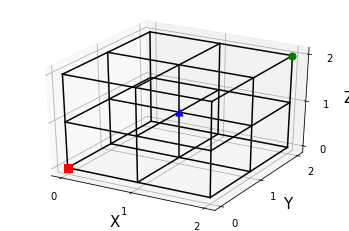

TypeError: super(type, obj): obj must be an instance or subtype of type

In [5]:
env = Environment()
agent = Agent()

max_step_number = 5

time_len = []

for max_step in range(max_step_number):

    v_table = np.zeros((env.reward.shape[0], env.reward.shape[1], env.reward.shape[2]), dtype=float)
    start_time = time.time()
    for i in range(env.reward.shape[0]):
        for j in range(env.reward.shape[1]):
            for k in range(env.reward.shape[2]):
                agent.set_pos([i,j,k])
                #print(agent.get_pos())
                G = state_value_function(env, agent, 0, max_step, 0)
                #print(type(G))
                v_table[i,j,k] = G 


    time_len.append(time.time()-start_time)
    print("max_step_number = {} total_time = {}(s)".format(max_step, np.round(time.time() - start_time,2)))

    show_3d_v_table(v_table, env)

plt.plot(time_len, 'o-k')
plt.xlabel('max_down')
plt.ylabel('time(s)')
plt.legent()
plt.show()